## tools

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from scipy.stats import skew
import time

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys
import time
import lightgbm as lgb
import xgboost as xgb

from bayes_opt import BayesianOptimization
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

In [3]:
class XgbWrapper:
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

class SklearnWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
    

class LightGBMRGWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

## load data

In [7]:
train = load_dataframe32("./bindata/train")
test = load_dataframe32("./bindata/test")

## features

https://www.kaggle.com/wentixiaogege/santander-46-features-add-andrew-s-feature-b337d2

In [41]:
def get_data():
    train = load_dataframe32("./bindata/train")
    test = load_dataframe32("./bindata/test")
    print('Train shape ', train.shape, ' Test shape ', test.shape)
    return train, test

def get_selected_features():
    return sorted([
        'f190486d6', 'c47340d97', 'eeb9cd3aa', '66ace2992', 'e176a204a',
        '491b9ee45', '1db387535', 'c5a231d81', '0572565c2', '024c577b9',
        '15ace8c9f', '23310aa6f', '9fd594eec', '58e2e02e6', '91f701ba2',
        'adb64ff71', '2ec5b290f', '703885424', '26fc93eb7', '6619d81fc',
        '0ff32eb98', '70feb1494', '58e056e12', '1931ccfdd', '1702b5bf0',
        '58232a6fb', '963a49cdc', 'fc99f9426', '241f0f867', '5c6487af1',
        '62e59a501', 'f74e8f13d', 'fb49e4212', '190db8488', '324921c7b',
        'b43a7cfd5', '9306da53f', 'd6bb78916', 'fb0f5dbfe', '6eef030c1'
    ])

def add_statistics(train, test):
    train_zeros = pd.DataFrame({'Percent_zero': ((train.values) == 0).mean(axis=0),
                                'Column': train.columns})
    
    high_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] < 0.70].values
    low_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] >= 0.70].values
    #This is part of the trick I think, plus lightgbm has a special process for NaNs
    train = train.replace({0:np.nan})
    test = test.replace({0:np.nan})

    cluster_sets = {"low":low_vol_columns, "high":high_vol_columns}
    for cluster_key in cluster_sets:
        for df in [train,test]:
            df["count_not0_"+cluster_key] = df[cluster_sets[cluster_key]].count(axis=1)
            df["sum_"+cluster_key] = df[cluster_sets[cluster_key]].sum(axis=1)
            df["var_"+cluster_key] = df[cluster_sets[cluster_key]].var(axis=1)
            df["median_"+cluster_key] = df[cluster_sets[cluster_key]].median(axis=1)
            df["mean_"+cluster_key] = df[cluster_sets[cluster_key]].mean(axis=1)
            df["std_"+cluster_key] = df[cluster_sets[cluster_key]].std(axis=1)
            df["max_"+cluster_key] = df[cluster_sets[cluster_key]].max(axis=1)
            df["min_"+cluster_key] = df[cluster_sets[cluster_key]].min(axis=1)
            df["skew_"+cluster_key] = df[cluster_sets[cluster_key]].skew(axis=1)
            df["kurtosis_"+cluster_key] = df[cluster_sets[cluster_key]].kurtosis(axis=1)
    train_more_simplified = train.drop(high_vol_columns,axis=1).drop(low_vol_columns,axis=1)
    colnames = list(train_more_simplified)
    return train, test, colnames

def add_statistics2(train, test):
    train_zeros = pd.DataFrame({'Percent_zero': ((train.values) == 0).mean(axis=0),
                                'Column': train.columns})
    
    high_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] < 0.70].sort_values().values
    low_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] >= 0.70].sort_values().values
    #This is part of the trick I think, plus lightgbm has a special process for NaNs
    train = train.replace({0:np.nan})
    test = test.replace({0:np.nan})

    cluster_sets = {"low":low_vol_columns, "high":high_vol_columns}
    for cluster_key in cluster_sets:
        for df in [train,test]:
            df["count_not0_"+cluster_key] = df[cluster_sets[cluster_key]].count(axis=1)
            df["sum_"+cluster_key] = df[cluster_sets[cluster_key]].sum(axis=1)
            df["var_"+cluster_key] = df[cluster_sets[cluster_key]].var(axis=1)
            df["median_"+cluster_key] = df[cluster_sets[cluster_key]].median(axis=1)
            df["mean_"+cluster_key] = df[cluster_sets[cluster_key]].mean(axis=1)
            df["std_"+cluster_key] = df[cluster_sets[cluster_key]].std(axis=1)
            df["max_"+cluster_key] = df[cluster_sets[cluster_key]].max(axis=1)
            df["min_"+cluster_key] = df[cluster_sets[cluster_key]].min(axis=1)
            df["skew_"+cluster_key] = df[cluster_sets[cluster_key]].skew(axis=1)
            df["kurtosis_"+cluster_key] = df[cluster_sets[cluster_key]].kurtosis(axis=1)
    train_more_simplified = train.drop(high_vol_columns,axis=1).drop(low_vol_columns,axis=1)
    colnames = list(train_more_simplified)
    return train, test, colnames

def fit_predict(data, y, test,colnames, params={}, log=True):
    # Get the features we're going to train on
    features = get_selected_features() + colnames #+ ['nb_nans', 'the_median', 'the_mean', 'the_sum', 'the_std', 'the_kur','the_max','the_min','the_var','count_not0']
    # Create folds
    folds = KFold(n_splits=8, shuffle=True, random_state=1)
    # Convert to lightgbm Dataset
    if log:
        dtrain = lgb.Dataset(data=data[features], label=np.log1p(y['target']), free_raw_data=False)
    else:
        dtrain = lgb.Dataset(data=data[features], label=y['target'], free_raw_data=False)
    # Construct dataset so that we can use slice()
    dtrain.construct()
    # Init predictions
    sub_preds = np.zeros(test.shape[0])
    oof_preds = np.zeros(data.shape[0])
    # Lightgbm parameters
    # Optimized version scores 0.40
    # Step |   Time |      Score |      Stdev |   p1_leaf |   p2_subsamp |   p3_colsamp |   p4_gain |   p5_alph |   p6_lamb |   p7_weight |
    #   41 | 00m04s |   -1.36098 |    0.02917 |    9.2508 |       0.7554 |       0.7995 |   -3.3108 |   -0.1635 |   -0.9460 |      0.6485 |
    lgb_params = {
        'objective': 'regression',
        'num_leaves': 60,
        'subsample': 0.6143,
        'colsample_bytree': 0.6453,
        'min_split_gain': np.power(10, -2.5988),
        'reg_alpha': np.power(10, -2.2887),
        'reg_lambda': np.power(10, 1.7570),
        'min_child_weight': np.power(10, -0.1477),
        'verbose': -1,
        'seed': 11,
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.03,
        'metric': 'l1',
    }
    lgb_params.update(params)
    print(lgb_params)
    # Run KFold
    for trn_idx, val_idx in folds.split(data):
        # Train lightgbm
        clf = lgb.train(
            params=lgb_params,
            train_set=dtrain.subset(trn_idx),
            valid_sets=dtrain.subset(val_idx),
            num_boost_round=10000,
            early_stopping_rounds=100,
            verbose_eval=50
        )
        # Predict Out Of Fold and Test targets
        # Using lgb.train, predict will automatically select the best round for prediction
        oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
        sub_preds += clf.predict(test[features]) / folds.n_splits
        # Display current fold score
        print(mean_squared_error(np.log1p(y['target'].iloc[val_idx]),
                                 oof_preds[val_idx]) ** .5)
    # Display Full OOF score (square root of a sum is not the sum of square roots)
    print('Full Out-Of-Fold score : %9.6f'
          % (mean_squared_error(np.log1p(y['target']), oof_preds) ** .5))

    return oof_preds, sub_preds

In [17]:
# Get the data
%time data, test = get_data()

# Get target and ids
y = data[['ID', 'target']].copy()
y["target"] = y.target.astype(np.float32)
del data['target'], data['ID']
sub = test[['ID']].copy()
del test['ID']

# Free some memory
gc.collect()

# Add features
%time data, test, colnames = add_statistics(data, test)
print(len(colnames))

# Predict test target
%time oof_preds, sub_preds = fit_predict(data, y, test, colnames)

# Store predictions
#y['predictions'] = np.expm1(oof_preds)
#y[['ID', 'target', 'predictions']].to_csv('reduced_set_oof.csv', index=False)
sub['target'] = np.expm1(sub_preds)
sub[['ID', 'target']].to_csv('submission-003-kernel.csv', index=False)

Train shape  (4459, 4993)  Test shape  (49343, 4992)
Wall time: 8.4 s
Wall time: 2min 37s
20
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 1.10891
[100]	valid_0's l1: 1.0444
[150]	valid_0's l1: 1.03061
[200]	valid_0's l1: 1.02928
[250]	valid_0's l1: 1.03093
Early stopping, best iteration is:
[170]	valid_0's l1: 1.02813
1.3170386551468414
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 1.1384
[100]	valid_0's l1: 1.10976
[150]	valid_0's l1: 1.10438
[200]	valid_0's l1: 1.10643
Early stopping, best iteration is:
[146]	valid_0's l1: 1.10388
1.4254317515007902
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 1.11417
[100]	valid_0's l1: 1.05948
[150]	valid_0's l1: 1.04352
[200]	valid_0's l1: 1.04413
[250]	valid_0's l1: 1.0451
Early stopping, best iteration is:
[175]	valid_0's l1: 1.04327
1.3295743690742763
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 1.14

In [42]:
# Get the data
%time data, test = get_data()

# Get target and ids
y = data[['ID', 'target']].copy()
y["target"] = y.target.astype(np.float32)
del data['target'], data['ID']
sub = test[['ID']].copy()
del test['ID']

# Free some memory
gc.collect()

# Add features
%time data, test, colnames = add_statistics2(data, test)
print(len(colnames))

# Predict test target
%time oof_preds, sub_preds = fit_predict(data, y, test, colnames)

# Store predictions
#y['predictions'] = np.expm1(oof_preds)
#y[['ID', 'target', 'predictions']].to_csv('reduced_set_oof.csv', index=False)
sub['target'] = np.expm1(sub_preds)
sub[['ID', 'target']].to_csv('submission-003-kernel2.csv', index=False)

Train shape  (4459, 4993)  Test shape  (49343, 4992)
Wall time: 1.45 s
Wall time: 2min 38s
20
{'objective': 'regression', 'num_leaves': 60, 'subsample': 0.6143, 'colsample_bytree': 0.6453, 'min_split_gain': 0.002518836627841738, 'reg_alpha': 0.005143988630287732, 'reg_lambda': 57.14786366718669, 'min_child_weight': 0.7117049722679207, 'verbose': -1, 'seed': 11, 'boosting_type': 'gbdt', 'max_depth': -1, 'learning_rate': 0.03, 'metric': 'l1'}
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 1.10884
[100]	valid_0's l1: 1.04491
[150]	valid_0's l1: 1.02807
[200]	valid_0's l1: 1.02739
[250]	valid_0's l1: 1.02951
Early stopping, best iteration is:
[172]	valid_0's l1: 1.02548
1.3143627963811153
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 1.13921
[100]	valid_0's l1: 1.10875
[150]	valid_0's l1: 1.10367
[200]	valid_0's l1: 1.10552
Early stopping, best iteration is:
[149]	valid_0's l1: 1.10347
1.4261678019487214
Training until 

In [48]:
test.shape

(49343, 5011)

In [46]:
sub_preds.shape

(49343,)

In [47]:
sub.shape

(49343, 2)

In [45]:
def modify(target_int_str):
    for i in range(1, len(target_int_str)):
        if target_int_str[i] == "0":
            return target_int_str[:i] + "0" * (len(target_int_str) - i)
        if i + 1 < len(target_int_str) and target_int_str[i] == "9" and target_int_str[i+1] == "9":
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 4 < i + 1 < len(target_int_str) and target_int_str[i] == "9" and int(target_int_str[i+1]) >= 7:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 4 < i + 1 < len(target_int_str) and target_int_str[i] == "1" and target_int_str[i+1] == "0":
            return str(int(target_int_str[:i]) - 1) + "0" * (len(target_int_str) - i)
        if 5 < i + 1 < len(target_int_str) and int(target_int_str[i+1]) > 7:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 5 < i + 1 < len(target_int_str) and int(target_int_str[i+1]) < 3:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
    return target_int_str

sub['target'] = np.expm1(sub_preds)
sub["target"] = sub.target.astype("int").astype("str").apply(modify)
sub[['ID', 'target']].to_csv('./result/submission-003-kernel2.csv', index=False)

In [94]:
data.head()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,count_not0_high,sum_high,var_high,median_high,mean_high,std_high,max_high,min_high,skew_high,kurtosis_high
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17,82371664.0,5.051358e+13,1866666.625,4845392.0,7107290.5,28000000.0,400000.0,2.525160,6.955070
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2200000.0,NaN,...,9,38175000.0,2.246969e+13,2225000.000,4241666.5,4740220.5,16000000.0,800000.0,2.353641,5.727639
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,23500000.0,1.308333e+13,6000000.000,7833333.5,3617089.0,12000000.0,5500000.0,1.694891,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2000000.0,NaN,2000000.000,2000000.0,NaN,2000000.0,2000000.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000000.0,NaN,...,7,64942000.0,1.625623e+14,5400000.000,9277429.0,12749993.0,37662000.0,1180000.0,2.446075,6.206917


In [95]:
save_dataframe32("./bindata/train_ftr", data[colnames])
save_dataframe32("./bindata/test_ftr", test[colnames])

In [18]:
colnames

['count_not0_low',
 'sum_low',
 'var_low',
 'median_low',
 'mean_low',
 'std_low',
 'max_low',
 'min_low',
 'skew_low',
 'kurtosis_low',
 'count_not0_high',
 'sum_high',
 'var_high',
 'median_high',
 'mean_high',
 'std_high',
 'max_high',
 'min_high',
 'skew_high',
 'kurtosis_high']

In [21]:
oof_preds.shape

(4459,)

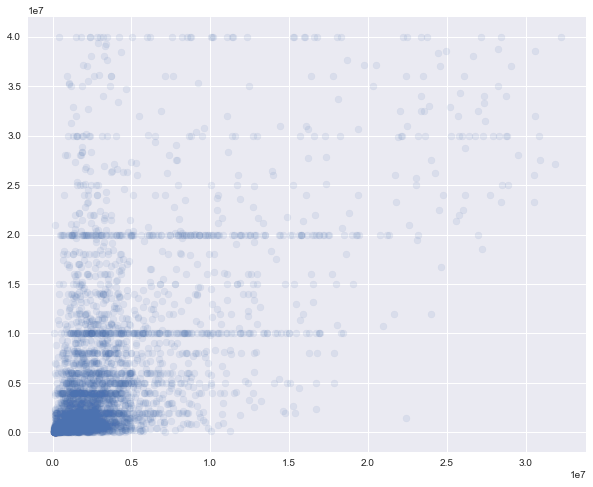

In [29]:
plt.figure(figsize=(10, 8))
plt.scatter(np.expm1(oof_preds), y.target.values, alpha=.1)
plt.show()

1.3506889858782811


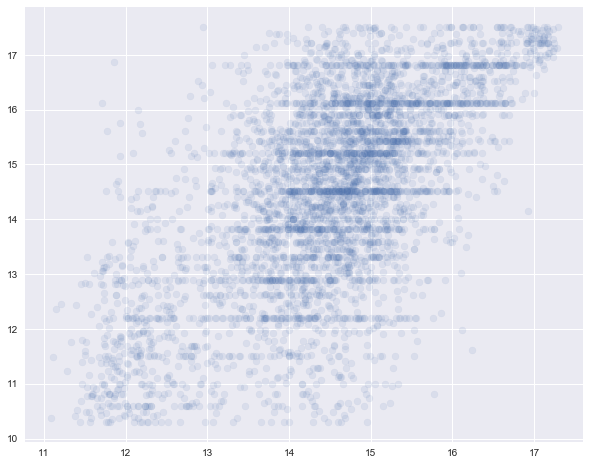

In [44]:
print(mean_squared_error(oof_preds, np.log1p(y.target.values)) ** .5)

plt.figure(figsize=(10, 8))
plt.scatter(oof_preds, np.log1p(y.target.values), alpha=.1)
plt.show()

In [52]:
pd.DataFrame({
    "oof": oof_preds,
    "exp": np.expm1(oof_preds),
    "mod": pd.Series(np.expm1(oof_preds)).astype("int").astype("str").apply(modify).astype("int")
}).head()

,oof,exp,mod
0,14.693802,2.406784e+06,2400000
1,14.800647,2.678178e+06,2678177
2,14.954028,3.122134e+06,3122133
3,14.063730,1.281740e+06,1281739
4,15.362937,4.699358e+06,4699357


1.350496100964864


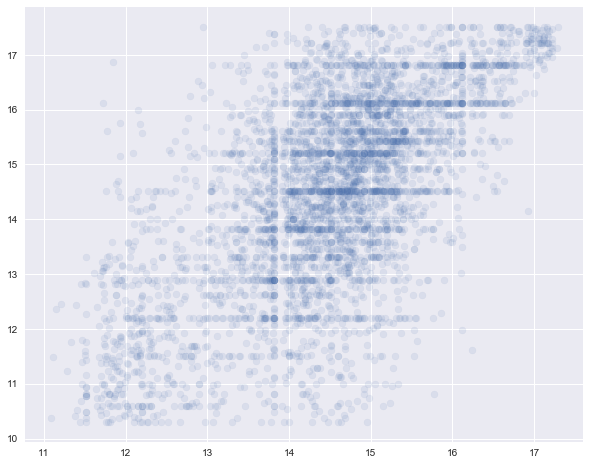

In [57]:
def modify(target_int_str):
    for i in range(1, len(target_int_str)):
        if target_int_str[i] in "0":
            return target_int_str[:i] + "0" * (len(target_int_str) - i)
    return target_int_str


oof_preds_mod = pd.Series(np.expm1(oof_preds)).astype("int").astype("str").apply(modify).astype(np.float64)
print(mean_squared_error(np.log1p(oof_preds_mod), np.log1p(y.target.values)) ** .5)

plt.figure(figsize=(10, 8))
plt.scatter(np.log1p(oof_preds_mod), np.log1p(y.target.values), alpha=.1)
plt.show()

1.3504920668445433


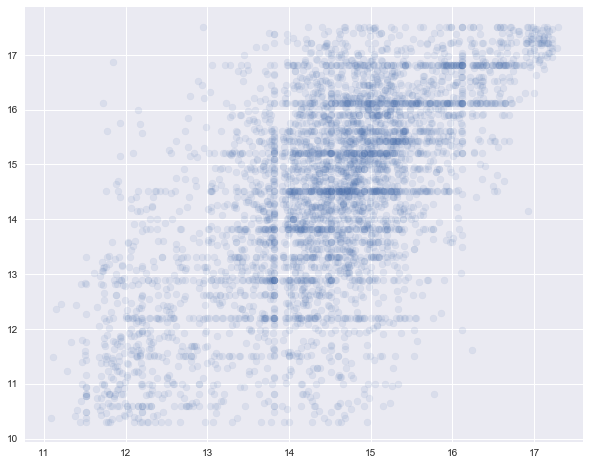

In [60]:
def modify(target_int_str):
    for i in range(1, len(target_int_str)):
        if target_int_str[i] in "0":
            return target_int_str[:i] + "0" * (len(target_int_str) - i)
        if i + 1 < len(target_int_str) and target_int_str[i] == "9" and target_int_str[i+1] == "9":
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        # if i + 1 < len(target_int_str) and target_int_str[i] == "1" and target_int_str[i+1] == "012":
        #     return str(int(target_int_str[:i]) - 1) + "0" * (len(target_int_str) - i)
    return target_int_str


oof_preds_mod = pd.Series(np.expm1(oof_preds)).astype("int").astype("str").apply(modify).astype(np.float64)
print(mean_squared_error(np.log1p(oof_preds_mod), np.log1p(y.target.values)) ** .5)

plt.figure(figsize=(10, 8))
plt.scatter(np.log1p(oof_preds_mod), np.log1p(y.target.values), alpha=.1)
plt.show()

1.350490372511802


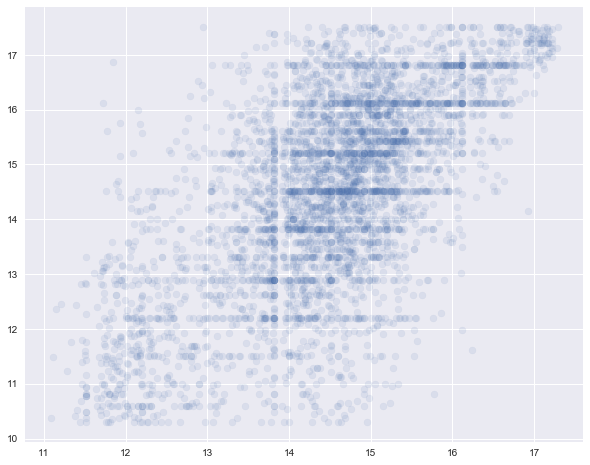

In [89]:
def modify(target_int_str):
    for i in range(1, len(target_int_str)):
        if target_int_str[i] == "0":
            return target_int_str[:i] + "0" * (len(target_int_str) - i)
        if i + 1 < len(target_int_str) and target_int_str[i] == "9" and target_int_str[i+1] == "9":
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 4 < i + 1 < len(target_int_str) and target_int_str[i] == "9" and int(target_int_str[i+1]) >= 7:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 4 < i + 1 < len(target_int_str) and target_int_str[i] == "1" and target_int_str[i+1] == "0":
            return str(int(target_int_str[:i]) - 1) + "0" * (len(target_int_str) - i)
        if 5 < i + 1 < len(target_int_str) and int(target_int_str[i+1]) > 7:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 5 < i + 1 < len(target_int_str) and int(target_int_str[i+1]) < 3:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
    return target_int_str

oof_preds_mod = pd.Series(np.expm1(oof_preds)).astype("int").astype("str").apply(modify).astype(np.float64)
print(mean_squared_error(np.log1p(oof_preds_mod), np.log1p(y.target.values)) ** .5)

plt.figure(figsize=(10, 8))
plt.scatter(np.log1p(oof_preds_mod), np.log1p(y.target.values), alpha=.1)
plt.show()

1. 1.3506889858782811   -origin
2. 1.350496100964864    -change0
3. 1.3504920668445433   -change0, 99
4. 1.3505144619426241   -change0, 10
5. 1.3504908789968233
6. 1.3504908749318019
7. 1.3504908731151697
8. 1.350490468473412
9. 1.350490372511802

## change target

In [4]:
def to_int(str16bit):
    try:
        result = 0
        for tok in str16bit:
            result *= 16
            result += "0123456789abcdef".index(tok)
    except:
        print("Error", str16bit)
    return result

def split_target_str(target_str):
    for i, tok in enumerate(reversed(target_str)):
        if tok not in "0.":
            break
    if i == 0:
        return (target_str, "")
    return (target_str[:-i], target_str[-i:])

train_id = pd.read_csv("./data/train_id.csv")
train_id["int_id"] = train_id.ID.apply(to_int)
train_id["target_str"] = train_id.target.apply(str)
train_id["target_split"] = train_id.target_str.apply(split_target_str)
train_id["target_p0"] = train_id.target_split.apply(lambda x: x[0])
train_id["target_p1"] = train_id.target_split.apply(lambda x: x[1])
train_id["target_len0"] = train_id.target_split.apply(lambda x: len(x[0]))
train_id["target_len1"] = train_id.target_split.apply(lambda x: len(x[1]))
gc.collect()
train_id.head()

,ID,target,int_id,target_str,target_split,target_p0,target_p1,target_len0,target_len1
0,000d6aaf2,38000000.0,14068466,38000000.0,"(38, 000000.0)",38,000000.0,2,8
1,000fbd867,600000.0,16504935,600000.0,"(6, 00000.0)",6,00000.0,1,7
2,0027d6b71,10000000.0,41773937,10000000.0,"(1, 0000000.0)",1,0000000.0,1,9
3,0028cbf45,2000000.0,42778437,2000000.0,"(2, 000000.0)",2,000000.0,1,8
4,002a68644,14400000.0,44467780,14400000.0,"(144, 00000.0)",144,00000.0,3,7


In [18]:
%time data, test = get_data()
data_ftr = load_dataframe32("./bindata/train_ftr")
test_ftr = load_dataframe32("./bindata/test_ftr")
colnames = list(data_ftr.columns)

Train shape  (4459, 4993)  Test shape  (49343, 4992)
Wall time: 1.35 s


In [8]:
train_id.head()

,ID,target,int_id,target_str,target_split,target_p0,target_p1,target_len0,target_len1
0,000d6aaf2,38000000.0,14068466,38000000.0,"(38, 000000.0)",38,000000.0,2,8
1,000fbd867,600000.0,16504935,600000.0,"(6, 00000.0)",6,00000.0,1,7
2,0027d6b71,10000000.0,41773937,10000000.0,"(1, 0000000.0)",1,0000000.0,1,9
3,0028cbf45,2000000.0,42778437,2000000.0,"(2, 000000.0)",2,000000.0,1,8
4,002a68644,14400000.0,44467780,14400000.0,"(144, 00000.0)",144,00000.0,3,7


In [19]:
len1_map = {
    0: 0,
    2: 0,
    3: 0,
    4: 1,
    5: 2,
    6: 3,
    7: 4,
    8: 5,
    9: 6
}

data = data.merge(data_ftr, left_index=True, right_index=True)
test = test.merge(test_ftr, left_index=True, right_index=True)
y_len1 = train_id[['ID', 'target_len1']].copy()
y_len1["target"] = y_len1.target_len1.astype(np.int32).map(len1_map)

In [20]:
data.shape

(4459, 5013)

In [21]:
test.shape

(49343, 5012)

In [26]:
def fit_predict(data, y, test,colnames, params={}, log=True):
    # Get the features we're going to train on
    features = get_selected_features() + colnames #+ ['nb_nans', 'the_median', 'the_mean', 'the_sum', 'the_std', 'the_kur','the_max','the_min','the_var','count_not0']
    # Create folds
    folds = KFold(n_splits=8, shuffle=True, random_state=1)
    # Convert to lightgbm Dataset
    if log:
        dtrain = lgb.Dataset(data=data[features], label=np.log1p(y['target']), free_raw_data=False)
    else:
        dtrain = lgb.Dataset(data=data[features], label=y['target'], free_raw_data=False)
    # Construct dataset so that we can use slice()
    dtrain.construct()
    # Init predictions
    sub_preds = np.zeros((test.shape[0], params["num_class"]))
    oof_preds = np.zeros((data.shape[0], params["num_class"]))
    # Lightgbm parameters
    # Optimized version scores 0.40
    # Step |   Time |      Score |      Stdev |   p1_leaf |   p2_subsamp |   p3_colsamp |   p4_gain |   p5_alph |   p6_lamb |   p7_weight |
    #   41 | 00m04s |   -1.36098 |    0.02917 |    9.2508 |       0.7554 |       0.7995 |   -3.3108 |   -0.1635 |   -0.9460 |      0.6485 |
    lgb_params = {
        'objective': 'regression',
        'num_leaves': 60,
        'subsample': 0.6143,
        'colsample_bytree': 0.6453,
        'min_split_gain': np.power(10, -2.5988),
        'reg_alpha': np.power(10, -2.2887),
        'reg_lambda': np.power(10, 1.7570),
        'min_child_weight': np.power(10, -0.1477),
        'verbose': -1,
        'seed': 11,
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.03,
        'metric': 'l1',
    }
    lgb_params.update(params)
    print(lgb_params)
    # Run KFold
    for trn_idx, val_idx in folds.split(data):
        # Train lightgbm
        clf = lgb.train(
            params=lgb_params,
            train_set=dtrain.subset(trn_idx),
            valid_sets=dtrain.subset(val_idx),
            num_boost_round=10000,
            early_stopping_rounds=100,
            verbose_eval=50
        )
        # Predict Out Of Fold and Test targets
        # Using lgb.train, predict will automatically select the best round for prediction
        oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
        sub_preds += clf.predict(test[features]) / folds.n_splits
        # Display current fold score
        # print(mean_squared_error(np.log1p(y['target'].iloc[val_idx]),
        #                         oof_preds[val_idx]) ** .5)
    # Display Full OOF score (square root of a sum is not the sum of square roots)
    # print('Full Out-Of-Fold score : %9.6f'
    #       % (mean_squared_error(np.log1p(y['target']), oof_preds) ** .5))

    return oof_preds, sub_preds

In [27]:
# Free some memory
gc.collect()

# Predict test target
%time oof_preds, sub_preds = fit_predict(data, y_len1, test, colnames, params={"objective": "multiclass", "metric": 'multi_logloss', "num_class": 7}, log=False)
# Store predictions
#y['predictions'] = np.expm1(oof_preds)
#y[['ID', 'target', 'predictions']].to_csv('reduced_set_oof.csv', index=False)
# sub['target'] = np.expm1(sub_preds)
# sub[['ID', 'target']].to_csv('submission-003-kernel.csv', index=False)

{'objective': 'multiclass', 'num_leaves': 60, 'subsample': 0.6143, 'colsample_bytree': 0.6453, 'min_split_gain': 0.002518836627841738, 'reg_alpha': 0.005143988630287732, 'reg_lambda': 57.14786366718669, 'min_child_weight': 0.7117049722679207, 'verbose': -1, 'seed': 11, 'boosting_type': 'gbdt', 'max_depth': -1, 'learning_rate': 0.03, 'metric': 'multi_logloss', 'num_class': 7}
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's multi_logloss: 1.65564
[100]	valid_0's multi_logloss: 1.56762
[150]	valid_0's multi_logloss: 1.53256
[200]	valid_0's multi_logloss: 1.51356
[250]	valid_0's multi_logloss: 1.50685
[300]	valid_0's multi_logloss: 1.50581
[350]	valid_0's multi_logloss: 1.50692
Early stopping, best iteration is:
[271]	valid_0's multi_logloss: 1.50507
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's multi_logloss: 1.67579
[100]	valid_0's multi_logloss: 1.58894
[150]	valid_0's multi_logloss: 1.55332
[200]	valid_0's multi_logloss: 1.5

In [32]:
oof_preds.argmax(axis=1)

array([4, 5, 5, ..., 2, 4, 6], dtype=int64)

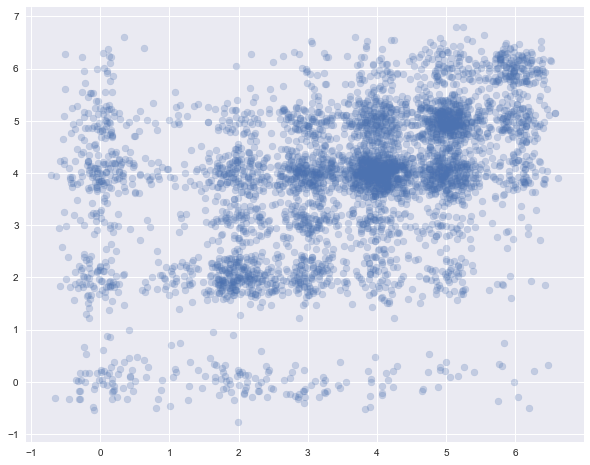

In [39]:
plt.figure(figsize=(10, 8))
plt.scatter(
    y_len1.target.values + np.random.normal(0, .25, y_len1.shape[0]),
    oof_preds.argmax(axis=1) + np.random.normal(0, .25, y_len1.shape[0]),
    alpha=.25
)
plt.show()